<h2>Photo-z validation metrics on Resampled Alhambra/Cosmos Data</h2>

This notebook shows how to load a .yaml /.p pickle file from all 100 of the resampled Alhambra/Cosmos validation files.

We then determine the error, from the spread of metric values from the 100 RS validation data, and also from the Cosmic Variance analysis.

In [4]:
import yaml
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import pickle

path_to_pickle_output_file = '/Users/hoyleb/Documents/python/modules/photoz-wg/validation/point_N1DG0.p'
path_to_cos_var_pickle_file = '/Users/hoyleb/Documents/python/modules/photoz-wg/validation/cosmic_variance_data/cosvariance_cosmos_z_metrics.p'

In [41]:
almost_black = '#262626'
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams.update({'font.size': 32, 
                     'axes.linewidth': 5,
                    'text.color': almost_black,
                    'xtick.major.size': 4,
                    'ytick.major.size': 4,
                    'legend.fancybox': True,
                    'figure.dpi': 300,
                    'legend.fontsize': 16,
                    'legend.framealpha': 0.8,
                    'legend.shadow': True,
                    'xtick.labelsize': 22,
                    'ytick.labelsize': 22})

<h3>Metrics of interst</h3>

Let us decide which metrics we want to measure. Edit this list with metrics that we measured from the validation script. Look at the structure of the validation .yaml file to understand this indexing.

In [24]:
#Form:
#'metric_name': [WHICH_Z_COLUMN, WAY_TO_COMPARE_DISTs, METRIC, [,MEASURED_ON]]
metrics = {'sigma_68': ['MEAN_Z', 'metrics_diffz','bh_photo_z_validation.sigma_68', 'delta_z'],
           'outlier_fraction': ['MEAN_Z', 'metrics_diffz', 
                                'bh_photo_z_validation.outlier_fraction', 'diff_1pz'],
           'median': ['MEAN_Z', 'metrics_diffz', 'numpy.median', 'delta_z'],
           'wl_metric': ['Z_MC', 'metrics_z1_z2', 'bh_photo_z_validation.wl_metric']
           }
bin_column = 'MEAN_Z'

<h3>Load results files</h3>

Now let's load the .p [pickle] file output from the validation pipeline, and also the cosmic variance results we calculated elsewhere [Ask Youngsoo/Ben/Markus for details].


In [14]:
res = pickle.load(open(path_to_pickle_output_file, 'r'))
cosvar = pickle.load(open(path_to_cos_var_pickle_file, 'r'))

In [15]:
files = res.keys()
def get_val(dct, ky):
    return dct[ky]

In [63]:
#get the error component from the resampled Alhambra data
m_res = {} #temporary value storage
metric_res = {} #this holds the median metric value, and std from the RS samples. Also the binned results
for m in metrics.keys(): 
    met_kys = metrics[m]
    m_res[m] ={'VALUES': [], 'BINS': {}, 'BIN_CENTER': []}
    metric_res[m] = {'VALUES':[], 'BINS': {}}
    for f in files:
        test_name = res[f].keys()[0]
        
        for j, ky in enumerate(met_kys):
            if j ==0:
                dct = get_val(res[f][test_name], ky)
            else:
                dct = get_val(dct, ky)
        
        m_res[m]['VALUES'].append(dct['VALUE'])
        z_bins = dct['bins'][bin_column]['BIN_CENTERS']

        for j, zbn in enumerate(z_bins):
            if j not in m_res[m]['BINS']:
                m_res[m]['BINS'][j] = []
                m_res[m]['BIN_CENTER'].append(zbn)
            m_res[m]['BINS'][j].append(dct['bins'][bin_column]['VALUE'][j])
    
    #get the median value and the error component from the standard deviation of the resampled data.
    metric_res[m]['VALUES'] = np.median(m_res[m]['VALUES']), np.std(m_res[m]['VALUES'])
    for j, zbn in enumerate(m_res[m]['BIN_CENTER']):
        metric_res[m]['BINS'][zbn] = np.median(m_res[m]['BINS'][j]), np.std(m_res[m]['BINS'][j])

<h3>Plot RS median values and errors</h3>

These error components are only from the (magnitude) ReSampled data.

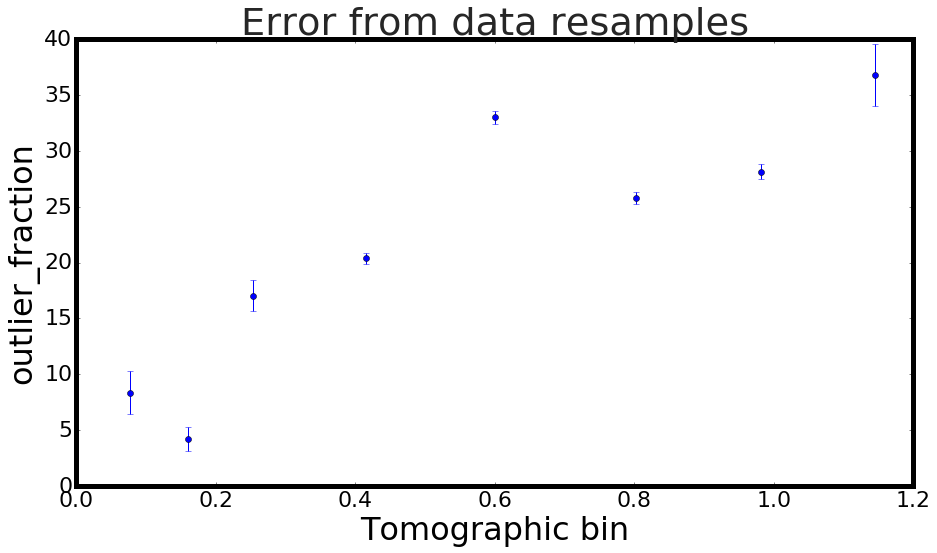

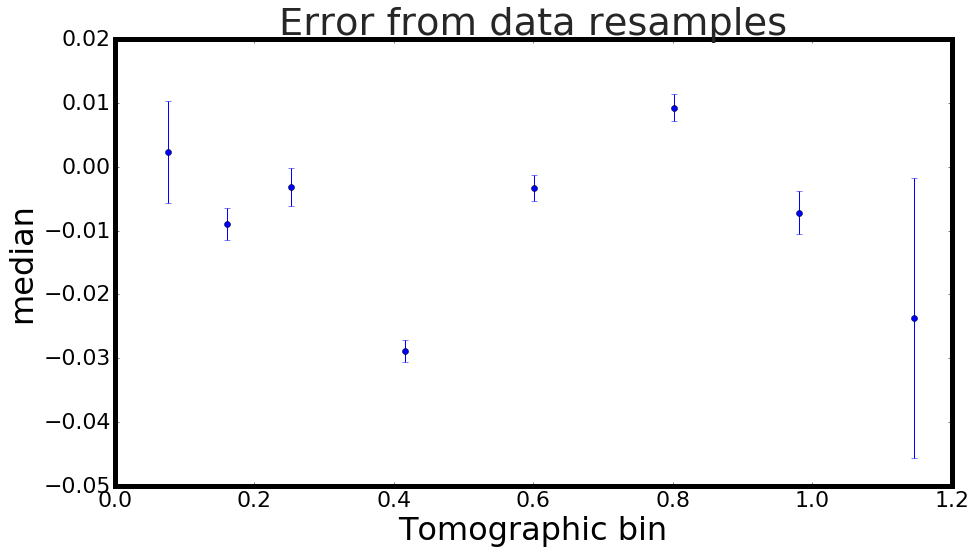

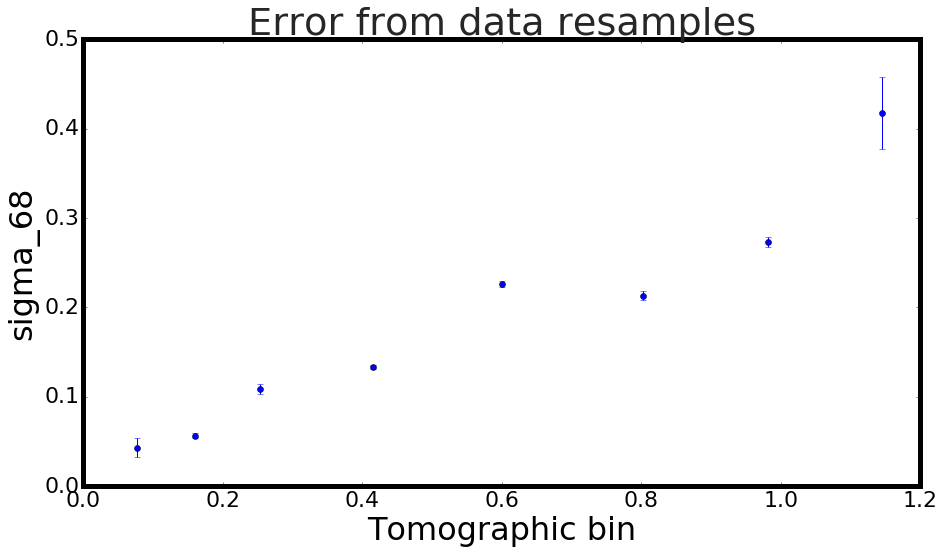

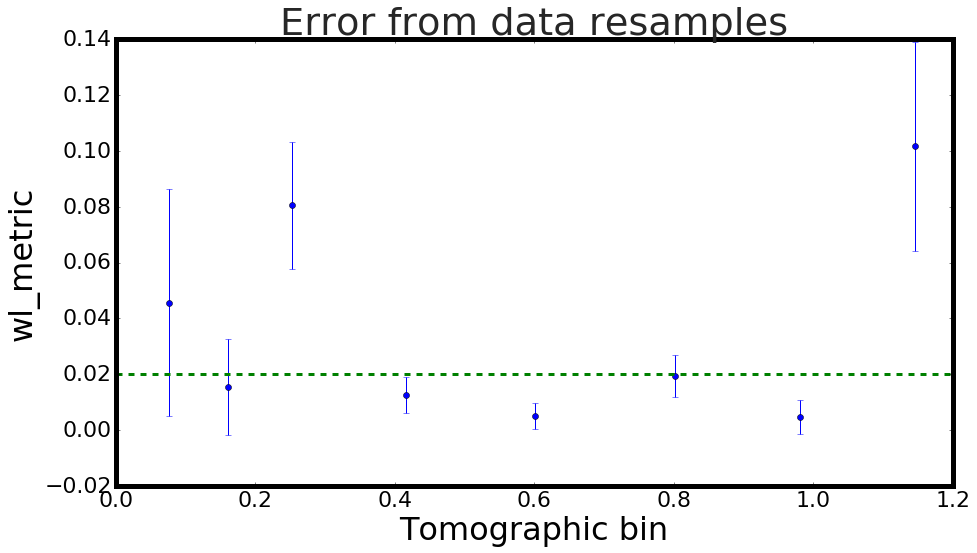

In [62]:
for m in metric_res:
    f= plt.figure()
    z = metric_res[m]['BINS'].keys()
    plt.errorbar(z, [metric_res[m]['BINS'][j][0] for j in z], yerr= [metric_res[m]['BINS'][j][1] for j in z],fmt='o')
    plt.xlabel('Tomographic bin')
    plt.title('Error from data resamples')
    plt.ylabel(m)
    if m =='wl_metric':
        plt.plot([0,1.2], [0.02,0.02],'--', linewidth=3)

<h3>Next add in CosmicVariance error component</h3>

We repeat the above, and additionally calculate the error on each metric from cosmic variance.

In [65]:
full_error_metric = {} #this will hold the median metric values, RS errors, AND CosVar Errors
for m in metrics.keys(): 
    z_bin_edges = np.array(cosvar['z_bins'])
    
    full_error_metric[m] = {'BINS':{}}
    m1 = m
    #argh! changed metric name. Silly me!
    if m =='outlier_fraction':
        m1 = 'outlierFrac'
    
    for j, zbn in enumerate(m_res[m]['BIN_CENTER']):
        ind = np.where(zbn > z_bin_edges)[0][0]
        met_arr_cos_var = [cosvar['res'][f][ind][m1] for f in cosvar['files']]
        full_error_metric[m]['BINS'][zbn] = np.median(m_res[m]['BINS'][j]), np.std(m_res[m]['BINS'][j]), np.std(met_arr_cos_var)


<h3>Plot both error components</h3>

Let's add the cosmic variance error in quadrature to the ReSample error, and plot the results for each metric, as a function of the tomographic bins.

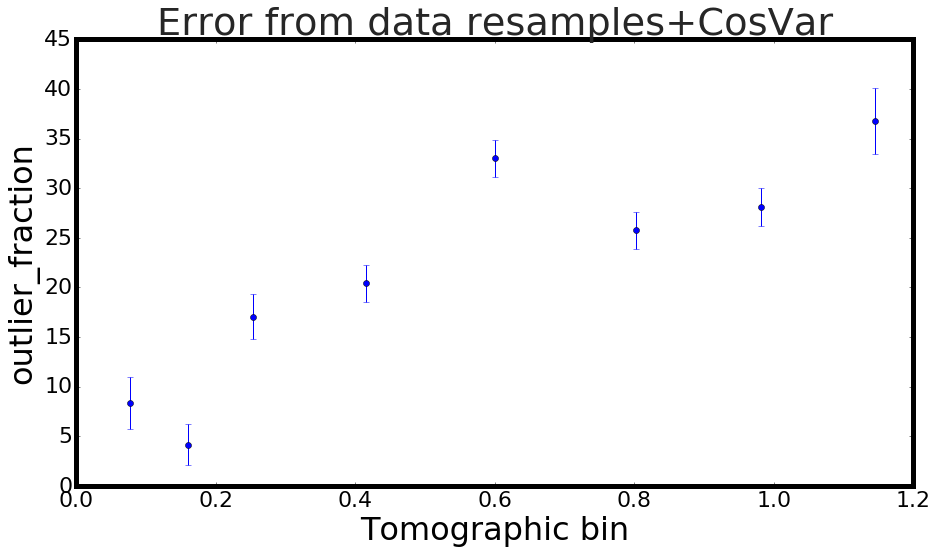

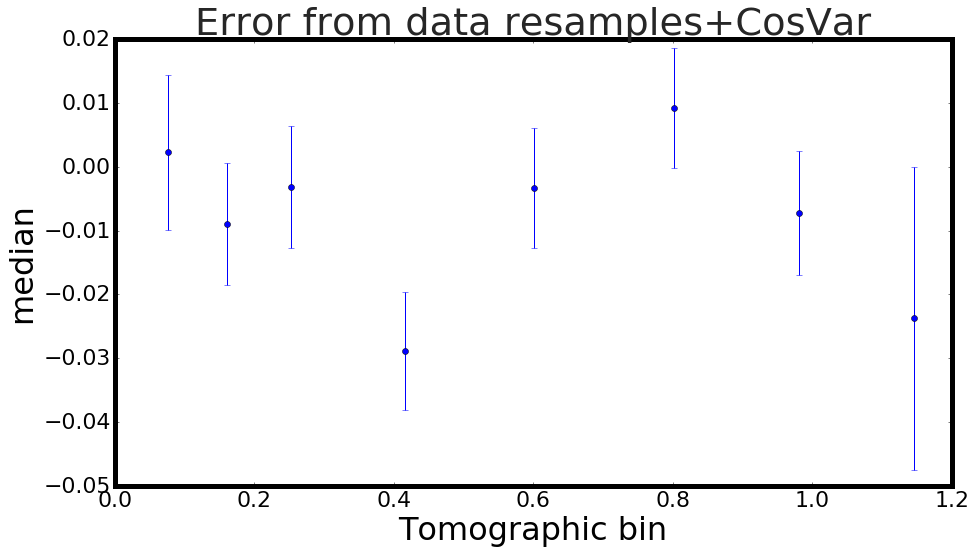

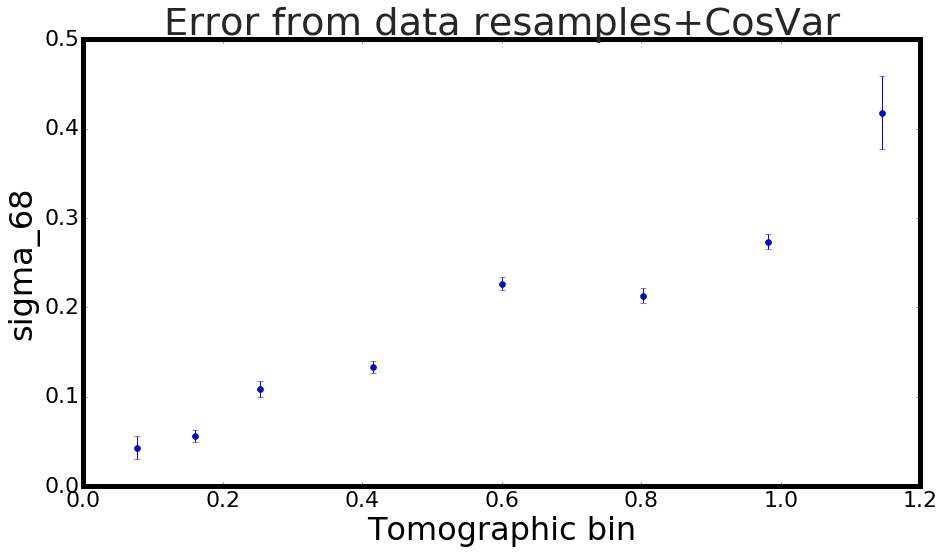

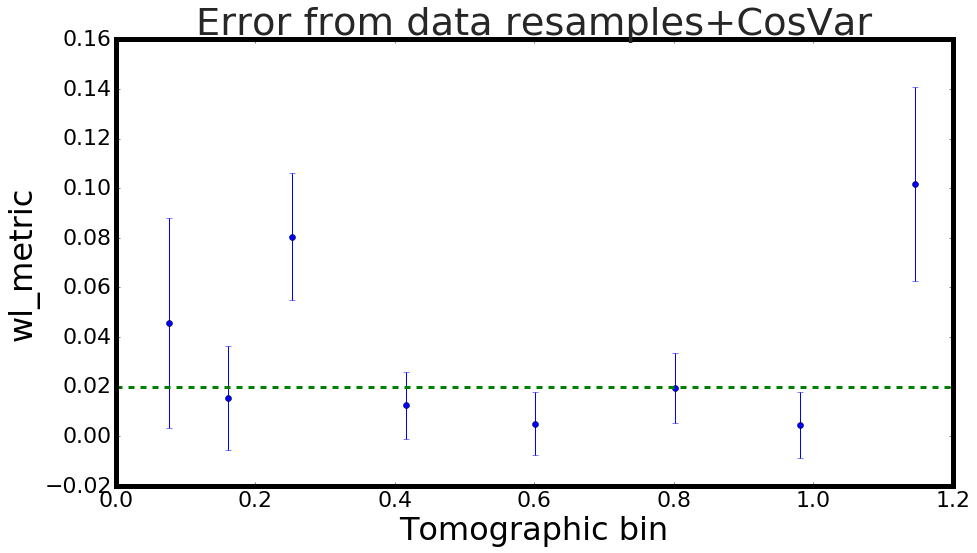

In [66]:
for m in full_error_metric:
    f= plt.figure()
    z = full_error_metric[m]['BINS'].keys()
    errRS = np.array([full_error_metric[m]['BINS'][j][1] for j in z]) #err from ReSample
    errCV =  np.array([full_error_metric[m]['BINS'][j][2] for j in z]) #err from CosVar
    err = np.sqrt(errRS**2 + errCV**2) #add in quadrature
    plt.errorbar(z, [full_error_metric[m]['BINS'][j][0] for j in z], yerr=err ,fmt='o')
    plt.xlabel('Tomographic bin')
    plt.title('Error from data resamples+CosVar')
    plt.ylabel(m)
    if m =='wl_metric':  #little hack to show WL requirements.
        plt.plot([0,1.2], [0.02,0.02],'--', linewidth=3)